In [1]:
from d2l import torch as d2l
import torch
import torch.nn as nn
from torch.nn import functional as F

In [2]:
%matplotlib inline

In [3]:
# Fuking shit auto compele is not working
%config Completer.use_jedi = False

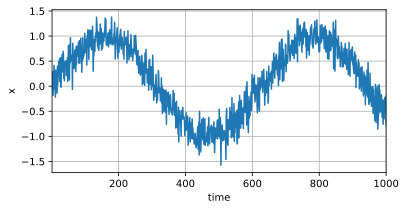

In [4]:
T = 1000
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01*time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

In [5]:
tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
labels = x[tau:].reshape((-1, 1))

In [6]:
batch_size, n_train = 16, 600
train_iter = d2l.load_array((features[:n_train], labels[:n_train]), batch_size, is_train=True)

In [7]:
def init_weight(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

def net():
    net = nn.Sequential(nn.Linear(4, 10),
                         nn.ReLU(),
                         nn.Linear(10, 1))
    net.apply(init_weight)
    return net

In [8]:
loss = nn.MSELoss()

In [9]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        print(f'Epoch {epoch + 1}, '
             f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

In [10]:
net = net()
train(net, train_iter, loss, 5, 0.01)

Epoch 1, loss: 0.072318
Epoch 2, loss: 0.061058
Epoch 3, loss: 0.060130
Epoch 4, loss: 0.056204
Epoch 5, loss: 0.054056


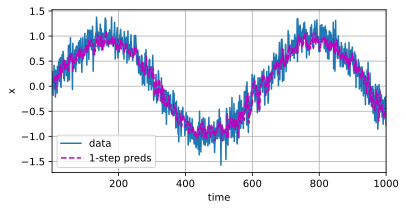

In [11]:
onestep_preds = net(features)
d2l.plot(
    [time, time[tau:]],
    [x.detach().numpy(), onestep_preds.detach().numpy()],
    'time',
    'x',
    legend=['data', '1-step preds'],
    xlim=[1, 1000],
    figsize=(6, 3)
)

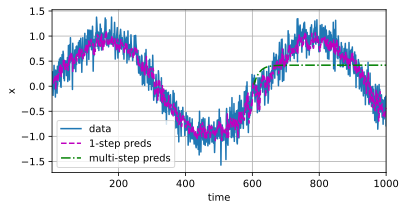

In [12]:
multisteps_pred = torch.zeros(T)
multisteps_pred[:n_train + tau] = x[:n_train + tau]

for i in range(n_train + tau, T):
    multisteps_pred[i] = net(multisteps_pred[i - tau:i].reshape((1, -1)))
d2l.plot(
    [time, time[tau:], time[n_train + tau:]],
    [x.detach().numpy(), onestep_preds.detach().numpy(), multisteps_pred[n_train + tau:].detach().numpy()],
    'time',
    'x',
    legend=['data', '1-step preds', 'multi-step preds'],
    xlim=[1, 1000],
    figsize=(6, 3)
)

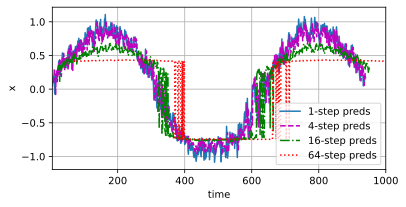

In [13]:
max_steps = 64
features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))

# column i are observations from i to i + T - tau - maxsteps + 1
for i in range(tau):
    features[:, i] = x[i:i + T - tau - max_steps + 1]

for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)
    
steps = (1, 4, 16, 64)

d2l.plot(
    [time[tau + i - 1:T - max_steps + i] for i in steps],
    [features[:, (tau + i - 1)].detach().numpy() for i in steps],
    'time',
     'x',
     legend=[f'{i}-step preds' for i in steps],
     xlim=[5, 1000],
     figsize=(6, 3)
)